In [101]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import linear_model
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error


In [40]:
#read census data into pandas dataframe selecting only relevant columns
census_2011 = pd.read_csv('./2011-india-census/india-districts-census-2011.csv', usecols=list(range(1,9)) + list(range(25,26)) +  list(range(35,40)) + list(range(68,70)) + list(range(117,118)))

In [41]:
#create new column representing percentage of households with a computer
census_2011['Percentage of Housholds with a Computer'] = census_2011['Households_with_Computer']/census_2011['Households']

In [42]:
#create new column representing percentage of households owned by occupant
census_2011['Percentage of Owned Households'] = census_2011['Ownership_Owned_Households']/census_2011['Households']

In [43]:
#create new column representing male to female ratio of each district
census_2011['Male to Female Ratio'] = census_2011['Male']/census_2011['Female']

In [44]:
#create new column reprensenting percentage of literate population in entire population
census_2011['Total Literacy Rate'] = census_2011['Literate']/census_2011['Population']

In [45]:
#create new column representing percentage of urban households 
census_2011['Percetnage of Urban Households'] = census_2011['Urban_Households']/census_2011['Households']

In [46]:
#create new column representing percentage of households with internet
census_2011['Percentage of Households with Internet'] = census_2011['Households_with_Internet']/census_2011['Households']

In [47]:
#create new column representing percentage of hindus in each district
census_2011['Percentage Hindu'] = census_2011['Hindus']/census_2011['Population']

In [48]:
#create bins for binning percentage of hindus in each district (0-33%, 33%-66%, 66%-100%)
bins = [0, .33, .66, 1]

#bin 'Percentage Hindu' and add to new column
census_2011['Binned Hindu'] = pd.cut(census_2011['Percentage Hindu'], bins)

#convert categories into dummy variables and drop first dummy
hindus = pd.get_dummies(census_2011['Binned Hindu'], drop_first=True)
census_2011 = pd.concat([census_2011, hindus], axis=1)

In [49]:
av = np.average(census_2011['Percentage of Owned Households'], weights = census_2011['Population'])
bins_av = [0,av,1]
census_2011['Binned Ownership'] = pd.cut(census_2011['Percentage of Owned Households'], bins_av)
ownership = pd.get_dummies(census_2011['Binned Ownership'],drop_first=True)
census_2011 = pd.concat([census_2011,ownership], axis = 1)

In [50]:
census_2011=census_2011.drop(columns=['Binned Ownership', 'Binned Hindu', 'Percentage Hindu'])

In [51]:
#select only relevant columns
data = census_2011.iloc[:, -10:]

# separate y (aka target or label)
target = census_2011['Total Literacy Rate']

# drop target leaving only features to build model on
features = data.drop(columns=['Total Literacy Rate'])


In [52]:
# sns.pairplot(features)

In [53]:
#split training and test data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [54]:
#initialize Linear Regression model 
lr = linear_model.LinearRegression()

In [55]:
#fit data to model
model = lr.fit(X_train, y_train)

In [56]:
#run test data through Model and test outputs equal to y_pred
y_pred = model.predict(X_test)


In [57]:
#model score (R^2 and Adjusted R2)
r2 = model.score(X_test, y_test)
ar2 = 1 - (1-model.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

In [58]:
#print R^2, Adjusted R^2, MSE, RMSE, and Normalized RMSE
print('R2:', r2, 'AdjustR2:', ar2)
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('Normalized RMSE:',np.sqrt(mean_squared_error(y_test, y_pred))/ y_test.std())

R2: 0.5412622756545789 AdjustR2: 0.5062738051536568
MSE: 0.005376857406864197
RMSE: 0.07332705780858931
Normalized RMSE: 0.6746508992612199


Text(0,0.5,'Predictions')

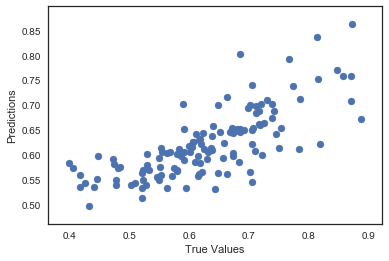

In [59]:
#create a residual plot comparing litrate predictions to actual rates
plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")

In [102]:
cv_5_results = np.mean((cross_val_score(model, features, target, cv=5)))
cv_10_results = np.mean((cross_val_score(model, features, target, cv=10)))
cv_20_results = np.mean((cross_val_score(model, features, target, cv=20)))

In [103]:
print(cv_5_results, cv_10_results, cv_20_results)

0.13646975517742801 0.09213384220784178 0.0004612881194525298


In [62]:
#initialize scaler
scaler = preprocessing.StandardScaler()

In [104]:
#fit training data to scaler (calcuate data mean and std), exclude categegorical data
scaler.fit(X_train.iloc[:,:-3])

#scale data (z = (x-mean / std))
features_scaled_train = pd.DataFrame(scaler.transform(X_train.iloc[:,:-3]), columns = X_train.columns[:-3], index = X_train.index)

#dataframe containing only categorical variables 
cat_variables = X_train.iloc[:, -3:]
features_scaled_train = pd.concat([features_scaled_train, cat_variables], axis=1)
# census_2011 = pd.concat([census_2011, hindus], axis=1)

In [64]:
#repeat above for test data
scaler.fit(X_test.iloc[:,:-3])
features_scaled_test = pd.DataFrame(scaler.transform(X_test.iloc[:,:-3]), columns = X_test.columns[:-3], index = X_test.index)
cat_variables_test = X_test.iloc[:, -3:]
features_scaled_test = pd.concat([features_scaled_test, cat_variables_test], axis=1)

In [105]:
features_scaled_train.rename(columns={features_scaled_train.columns[6]: 'HINDUS ZERO TO 33%', features_scaled_train.columns[7]: 'HINDUS 66% TO 100%', features_scaled_train.columns[8]:'OWNERSHIP OF HOUSEHOLDS > MEAN' 
                               
                               }, inplace=True)

features_scaled_test.rename(columns={features_scaled_test.columns[6]: 'HINDUS ZERO TO 33%', features_scaled_test.columns[7]: 'HINDUS 66% TO 100%', features_scaled_test.columns[8]:'OWNERSHIP OF HOUSEHOLDS > MEAN' 
                               
                               }, inplace=True)

In [106]:
poly = preprocessing.PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
features_interactions_train = pd.DataFrame(poly.fit_transform(features_scaled_train), columns=poly.get_feature_names(features_scaled_train.columns))
features_interactions_test = pd.DataFrame(poly.fit_transform(features_scaled_test), columns=poly.get_feature_names(features_scaled_test.columns))

In [107]:
from sklearn.feature_selection import VarianceThreshold

In [68]:
thresholder = VarianceThreshold(threshold=.5)

In [69]:
def variance_threshold_selector(data, threshold = .5): 
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

In [70]:
features_selected_train = variance_threshold_selector(features_interactions_train)

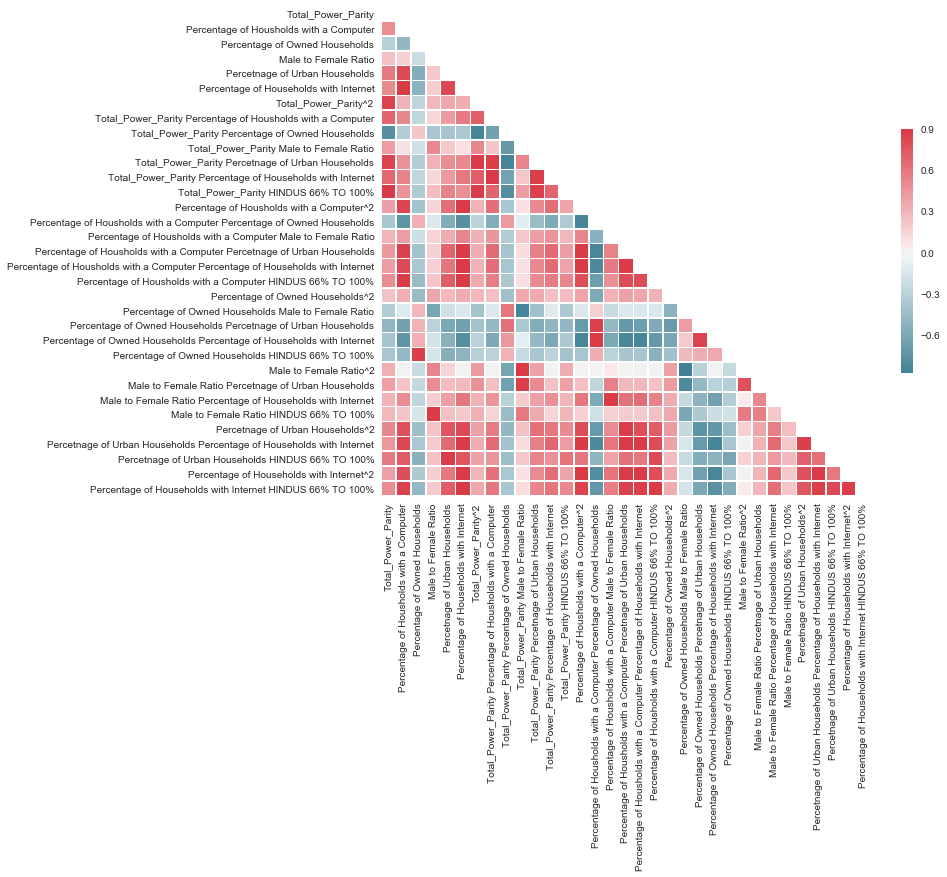

In [71]:
sns.set(style = 'white')

corr = features_selected_train.corr()

mask = np.zeros_like(corr,dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (11,9))

cmap = sns.diverging_palette(220,10,as_cmap=True)

sns.heatmap(corr,mask=mask,cmap=cmap,vmax=0.9,center=0,square=True,linewidths=0.5,cbar_kws={'shrink' : 0.5})

In [72]:
corr_matrix = features_selected_train.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))

to_drop = [column for column in upper.columns if any(upper[column]>0.95)]

In [73]:
to_drop

['Total_Power_Parity Percentage of Households with Internet',
 'Total_Power_Parity HINDUS 66% TO 100%',
 'Percentage of Housholds with a Computer Percetnage of Urban Households',
 'Percentage of Housholds with a Computer Percentage of Households with Internet',
 'Percentage of Owned Households Percentage of Households with Internet',
 'Male to Female Ratio Percentage of Households with Internet',
 'Percetnage of Urban Households Percentage of Households with Internet',
 'Percentage of Households with Internet^2',
 'Percentage of Households with Internet HINDUS 66% TO 100%']

In [74]:
features_selected_train.drop(columns=to_drop,inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [75]:
model_2 = lr.fit(features_selected_train, y_train)

In [76]:

features_selected_test = features_interactions_test[features_selected_train.columns]
y_pred_2 = model_2.predict(features_selected_test)

In [77]:
r2_2 = model_2.score(features_selected_train, y_train)
ar2_2 = 1 - (1-model_2.score(features_selected_train, y_train))*(len(y_test)-1)/(len(y_test)-features_selected_test.shape[1]-1)

In [78]:
print('R2:', r2_2, 'AdjustR2:', ar2_2)
print('MSE:', mean_squared_error(y_test, y_pred_2))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_2)))
print('Normalized RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_2))/ y_test.std())

R2: 0.5012456099862355 AdjustR2: 0.3850309948373971
MSE: 0.005027070035710852
RMSE: 0.07090183379653062
Normalized RMSE: 0.6523374503169526


In [97]:
cv_5_results = np.mean((cross_val_score(model_2, features_selected_train, y_train, cv=5)))
cv_10_results = np.mean((cross_val_score(model_2, features_selected_train, y_train, cv=10)))
cv_20_results = np.mean((cross_val_score(model_2, features_selected_train, y_train, cv=20)))

In [98]:
print(cv_5_results, cv_10_results, cv_20_results)

0.24454584860797376 0.22105899770479498 0.14144776211046736


In [81]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression,f_classif, chi2

In [82]:
def information_selector(X, y, scoring, k=5):
    selector = SelectKBest(score_func=scoring, k=k)
    selector.fit(X, y)
    return X[X.columns[selector.get_support(indices=True)]]

In [83]:
test = SelectKBest(score_func=mutual_info_regression, k=12)
fit = test.fit(features_selected_train, y_train)


In [84]:
features_selected_train_k_best = information_selector(features_selected_train, y_train, mutual_info_regression, k=12)

In [86]:
model_3 = lr.fit(features_selected_train_k_best, y_train)

In [91]:
features_selected_test_k_best = features_interactions_test[features_selected_train_k_best.columns]
y_pred_3 = model_3.predict(features_selected_test_k_best)

In [95]:
r2_3 = model_3.score(features_selected_train_k_best, y_train)
ar2_3 = 1 - (1-model_3.score(features_selected_train_k_best, y_train))*(len(y_test)-1)/(len(y_test)-features_selected_test_k_best.shape[1]-1)


In [96]:
print('R2:', r2_3, 'AdjustR2:', ar2_3)
print('MSE:', mean_squared_error(y_test, y_pred_3))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_3)))
print('Normalized RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_3))/ y_test.std())

R2: 0.4615704269506622 AdjustR2: 0.40538647150203566
MSE: 0.005663881278340199
RMSE: 0.07525876213664558
Normalized RMSE: 0.6924236846555535


In [99]:
cv_5_results = np.mean((cross_val_score(model_3, features_selected_train_k_best, y_train, cv=5)))
cv_10_results = np.mean((cross_val_score(model_3, features_selected_train_k_best, y_train, cv=10)))
cv_20_results = np.mean((cross_val_score(model_3, features_selected_train_k_best, y_train, cv=20)))

In [100]:
print(cv_5_results, cv_10_results, cv_20_results)

0.4166305796758675 0.4207764622609747 0.39730442578167013
